# Redes Neuronales Convolucionales (CNN)

- La meta es reducir el ancho/alto y aumentar la profundidad
- Transformar información espacial en features (feature maps)

![cnn.jpeg](../../Imagenes/cnn.jpeg)

### Capa convolucional:
- Su función es aumentar la profundidad (espacialidad --> features)

##### Hyperparámetros
- **filters**: Sirve para aumentar la dimensionalidad de una CNN.
- **kernel_size**: Sirve para incrementar el tamaño/complejidad de los patrones detectados. Tamaño del cuadrado.
- **Stride**: Paso. Determina el tamaño de los filtros del siguiente nivel.
- **Padding**: Que hacemos con los bordes? 
    - 'same': Agrega padding para mantener el tamaño original.
    - 'valid': Sin padding. Reduce el tamaño de la salida.

### Capa Pooling
---
#### MaxPooling
- Su función es reducir la cantidad de parámetros, bajar la dimensionalidad.

![Max-polling.png](../../Imagenes/Max-polling.png)

##### Hyperparámetros
- Pool size
- Strides: En este caso esta en None por default lo que significa que strides=pool_size

---
#### Global Average Pooling  
- Un resultado (Promedio) por cada canal.
- Utilizada para reducir la dimensionalidad en las ultimas capas.

![GAP.png](../../Imagenes/GAP.png)

---
### Ejemplo

In [46]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from fnn_helper import PlotLosses
from keras.utils import np_utils
import keras
from keras.datasets import cifar10
import numpy as np
import os

##### Descargo y guardo archivos

In [24]:
from urllib.request import urlretrieve

if not os.path.exists("cnn2.cifar.hdf5"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1fFs1RlbzZ3G_Ee86rqR5SakRw1V7k3Bl&export=download", "cnn2.cifar.hdf5")

if not os.path.exists("aug_model.weights.best.hdf5"):
    urlretrieve("https://drive.google.com/uc?authuser=0&id=1y7lCbRRiILhYA2w0Dof4R0MeVN2hpfAQ&export=download", "aug_model.weights.best.hdf5")


In [42]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [48]:
dropout = 0.25

model = Sequential()
model.add(Convolution2D(filters=6, strides=1, kernel_size=6, padding='same',input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=12, strides=2, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=24, strides=2, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 6)         654       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 6)         24        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 12)        1812      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 12)        48        
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 12)        0         
__________

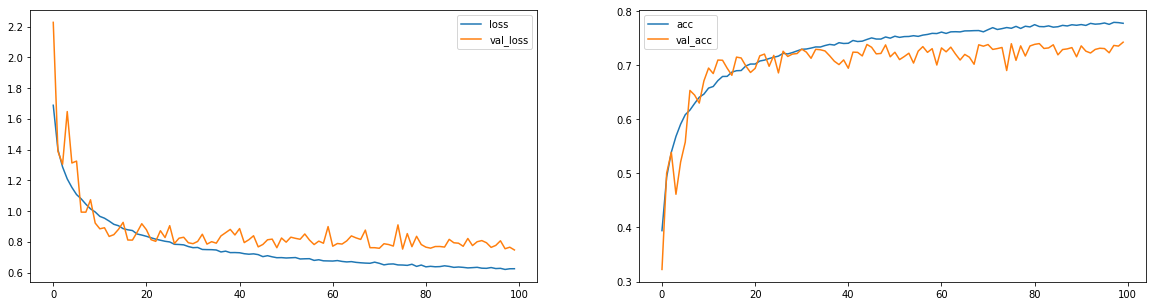


Epoch 00100: val_loss improved from 0.75263 to 0.74680, saving model to aug_model.weights.best.hdf5


In [49]:
lr = 0.001
plot_interval = 1
epochs = 100
batch_size = 32

adam = optimizers.Adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_valid, y_val_categorical=y_valid)

model.fit(x_train, 
          y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_valid, y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

In [50]:
model.load_weights('aug_model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.7839789877891541
accuracy:  0.7305
